# Imputation with Spritz gaps and masked glitches

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.signal
import time

## 1. Load time-domain LDC data

We are currently interested only in the impact of gaps on the Spritz MBHB-1 dataset. To achieve that we separate the effect of glitches from the effect of gaps in the Spritz data, and we do so by creating ad-hoc datasets with only gaps.

### 1.1. Download and access data

Download LDC 2b *Spritz* MBHB-1 data from the LDC official website (https://lisa-ldc.lal.in2p3.fr/challenge2b) and save them to the `./data/` folder.

In [7]:
# import data
fname = '../../data/LDC2_spritz_mbhb1_training_v2.h5'
# open file with h5py
fid = h5py.File(fname)

In [8]:
# define function to print all attributes of hdf5 file recursively 
# from the LDC quicklook notebooks
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")
# print all dataset attributes (useful to see what's inside the HDF5 file)
fid.visititems(print_attrs)

clean
    clean/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
gal
    gal/tdi
        coord: t
        dt: 5.0
        t0: 8899200.0
        units: dimensionless
header
    header/date
instru
    instru/config
        instru/config/LISA_AAFILTER_ATTENUATION
        instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        instru/config/LISA_ACC_NOISE_A_LEVEL
        instru/config/LISA_ACC_NOISE_F_KNEE
        instru/config/LISA_ACC_NOISE_USE_PZM
        instru/config/LISA_ADC_RECURSION_ORDER
        instru/config/LISA_BACKLINK_NOISE_A_LEVEL
        instru/config/LISA_BACKLINK_NOISE_F_KNEE
        instru/config/LISA_DEBUG_CLOCK_OFFSETS
        instru/config/LISA_FREQUENCY_OFFSETS_12
        instru/config/LISA_FREQUENCY_OFFSETS_13
        instru/config/LISA_FREQUENCY_OFFSETS_21
        instru/config/LISA_FREQUENCY_OFFSETS_23
        instru/config/LISA_FREQUENCY_OFFSETS_31
        instru/config/LIS

### 1.2. Import the Spritz `tdi` datasets

The Spritz HDF5 file is structured in various groups:
- group `obs` containing `noise + signal + artifacts` (gaps + glitches)
- group `clean` containing `noise + signal`
- group `sky` containing `signal`
- group `noisefree` containing `signal + artifacts` (gaps + glitches)
- group `gal` containing `galaxy confusion background`

Each of these groups hosts a dataset `tdi` that contains TDI combinations $X$, $Y$ and $Z$.

The import function `load_tdi_timeseries` also builds the missing TDI dataset:
- TDI dataset `noise` containing `noise`
- TDI dataset `noise` containing `noise + glitches`
- TDI dataset `clean_gapped` containing `noise + signal + gaps`
- TDI dataset `noise_gapped` containing `noise + gaps`
- TDI dataset `sky_gapped` containing `signal + gaps`
- TDI dataset `noise` containing `noise + glitches + gaps`

In [9]:
# Print the tdi dataset object
print(fid['obs/tdi'])

<HDF5 dataset "tdi": shape (535680, 1), type "|V32">


In [10]:
from bayesdawn.connect.fillgaps import load_tdi_timeseries

Let's load all datasets as numpy-recarray objects in a single dictionary `tdi`:

In [11]:
tdi = load_tdi_timeseries(fname = fname)
tdi

{'obs': array([( 8899200., -1.20843503e-21,  1.03963281e-21, -3.83668942e-21),
        ( 8899205.,  4.66545351e-22, -1.35315602e-21,  7.09159015e-21),
        ( 8899210.,  2.48226674e-21, -1.04844445e-21,  1.09270023e-21),
        ...,
        (11577585., -9.29828606e-21, -6.92159820e-21,  7.19464761e-21),
        (11577590.,  5.70021014e-21, -9.60595940e-22, -4.94114626e-21),
        (11577595., -4.30521175e-21,  8.29780973e-21,  2.00536395e-20)],
       dtype=[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]),
 'clean': array([( 8899200., -1.25114678e-21,  1.14531093e-21, -3.89541179e-21),
        ( 8899205.,  4.31402381e-22, -1.24788979e-21,  7.02567084e-21),
        ( 8899210.,  2.45469255e-21, -9.43590111e-22,  1.01958399e-21),
        ...,
        (11577585., -9.25158104e-21, -7.01214611e-21,  7.23237724e-21),
        (11577590.,  5.74428807e-21, -1.04392022e-21, -4.90782046e-21),
        (11577595., -4.26376092e-21,  8.22170907e-21,  2.00825614e-20)],
       dtype=[('t', 

Let's take a look at the `'obs'` dataset:

In [12]:
tdi['obs']['X']

array([-1.20843503e-21,  4.66545351e-22,  2.48226674e-21, ...,
       -9.29828606e-21,  5.70021014e-21, -4.30521175e-21])

In [13]:
# dataset is a numpy.recarray object with the length of the data time-series and fields ['t','X','Y','Z']
print(tdi['obs'])
print(tdi['obs'].dtype)

[( 8899200., -1.20843503e-21,  1.03963281e-21, -3.83668942e-21)
 ( 8899205.,  4.66545351e-22, -1.35315602e-21,  7.09159015e-21)
 ( 8899210.,  2.48226674e-21, -1.04844445e-21,  1.09270023e-21) ...
 (11577585., -9.29828606e-21, -6.92159820e-21,  7.19464761e-21)
 (11577590.,  5.70021014e-21, -9.60595940e-22, -4.94114626e-21)
 (11577595., -4.30521175e-21,  8.29780973e-21,  2.00536395e-20)]
[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')]


Set up dataset constant values:

In [15]:
# number of samples to skip at the beginning of the file
skip = 100 
# length of time-series
ndata = len(tdi['obs'][skip:])
# time step
dt = tdi['obs']['t'][1]-tdi['obs']['t'][0]
# sampling frequency
fs = 1.0/dt
tobs = ndata * dt # observation time

fmin = np.round(1.0/(tobs),9)+2e-9 # minumum frequency


print('skip','ndata','dt', 'fs', 'tobs\t', 'fmin', sep='\t',end='\n'+60*'-'+'\n')
print(skip, ndata, dt, fs, tobs, fmin, sep='\t')

skip	ndata	dt	fs	tobs		fmin
------------------------------------------------------------
100	535580	5.0	0.2	2677900.0	3.75e-07


## 2. Build orthogonal TDI combinations

We can proceed in two different ways to build orthogonal TDI combinations for all the datasets of our interest, i.e. `n+s`, `s`, `n`, `n+s+g` `n+g` data, according to our needs.

1. We can create separate numpy rec-arrays, one for each separate dataset
2. We can create a dictionary containing orthogonal TDI combinations for all imported datasets them


Each of these can then be wired into the Spritz analysis.

In [10]:
from bayesdawn.connect.fillgaps import build_orthogonal_tdi

In [11]:
# option 1 - separate numpy rec-arrays
td_data = build_orthogonal_tdi(tdi['obs'])
td_datans = build_orthogonal_tdi(tdi['clean'])
td_datas  = build_orthogonal_tdi(tdi['sky'])
td_datan  = build_orthogonal_tdi(tdi['noise'])
td_datag  = build_orthogonal_tdi(tdi['clean_gapped'])
td_datang = build_orthogonal_tdi(tdi['noise_gapped'])
td_datangg = build_orthogonal_tdi(tdi['noiseglitch_gapped'])

print(td_datans.dtype.names)

# # option 2 - single dictionary containing all numpy recarrays
# data = build_orthogonal_tdi(tdi)
# print(data.keys())
# print(data['obs'].dtype.names)

('t', 'A', 'E', 'T')


## 3. Define useful functions 

All these will end up in a separate file afterwards.

- `fft_olap_psd`: function that evaluates PSD equivalent to `scipy.signal.welch` and also evaluates FFT at the same time
- `generate_freq_data`: function that applies `fft_olap_psd` to each group inside data and groups results in a single `numpy.recarray` with the same structure of time-domain data.
- `plot_compare_spectra_timeseries`: modified version of `lisabeta_fill_gaps.plot_compare_spectra` function that plots noise spectra and distribution of real/imag part of PSD/noise_model

In [12]:
from bayesdawn.connect.fillgaps import fft_olap_psd, generate_freq_data, plot_compare_spectra_timeseries

In [13]:
# generate data in the right format for the MBHB search code
# split needs to be set to True

# noise data
datan, psddatan, scalefacn = generate_freq_data(td_datan, split=True, fmin = fmin, win='boxcar')
# noise + signal data
datans, psddatans, scalefacns = generate_freq_data(td_datans, split=True, fmin = fmin, win='boxcar')
# signal data
data, psddata, scalefac = generate_freq_data(td_datas, split=True, fmin = fmin, win='boxcar')

In [14]:
for param, val in zip(fid['sky/cat'].attrs.keys(),fid['sky/cat'][()]):
    print(param, ':', val)

CoalescenceTime : -0.30300442294174235
Distance : 1.2925183861048521
EclipticLatitude : 1.2031361791056812
EclipticLongitude : 2.097303543065685
Inclination : 0.747377
InitialAzimuthalAngleL : 0.8388
InitialPolarAngleL : 1323277.47932
Mass1 : 612485.5060299999
Mass2 : 11526944.921879262
PhaseAtCoalescence : 1.2201968860015653
PolarAngleOfSpin1 : 2.6919824500032945
PolarAngleOfSpin2 : 1.808398497592109
Polarization : 1.73941
Redshift : 13470.983558972537
Spin1 : 31558149.763545603
Spin2 : 3.0


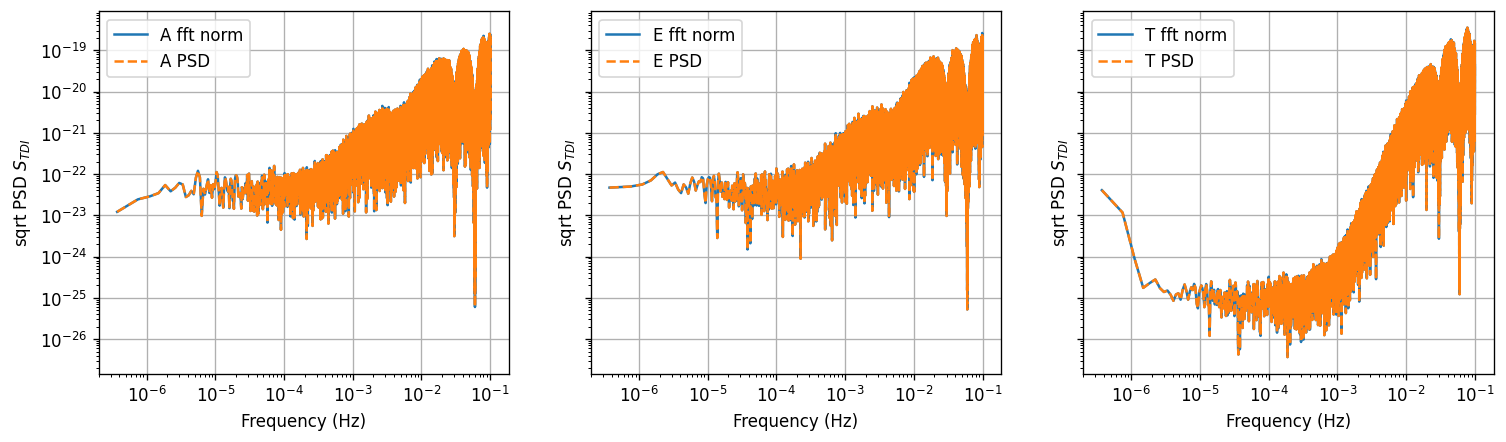

In [15]:
# plot data
fig, ax = plt.subplots(1,3,figsize=(15,4),dpi=120, sharey=True)
ax[0].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,1]+1j*datan[:,2]))), label='A fft norm')
ax[1].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,3]+1j*datan[:,4]))), label='E fft norm')
ax[2].loglog(datan[:,0],np.sqrt(scalefacn*np.square(np.absolute(datan[:,5]+1j*datan[:,6]))), label='T fft norm')

ax[0].loglog(psddatan[:,0], np.sqrt(psddatan[:,1]), ls='--', label='A PSD')
ax[1].loglog(psddatan[:,0], np.sqrt(psddatan[:,2]), ls='--', label='E PSD')
ax[2].loglog(psddatan[:,0], np.sqrt(psddatan[:,3]), ls='--', label='T PSD')

for i in range(3):
    ax[i].set_xlabel('Frequency (Hz)')
    ax[i].set_ylabel(r'sqrt PSD $S_{TDI}$')
    ax[i].legend()
    ax[i].grid()                                                

For comparing spectra, and compare data with noise models.

Here we compare the three data realizations (noise, signal and noise + signal) and evaluate the gaussianity of the noise realization.

Here we compare the full noise + signal dataset with the only-noise dataset, applying `LISAnoise` as noise model for the TDI noise spectra.

Note that `n + s` data deviate significantly from the Gaussian behavior for A and E, but not as much for T.

In [16]:
from bayesdawn.connect.fillgaps import plot_compare_spectra_timeseries
from bayesdawn.connect.lisabeta_fill_gaps import plot_compare_spectra

/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


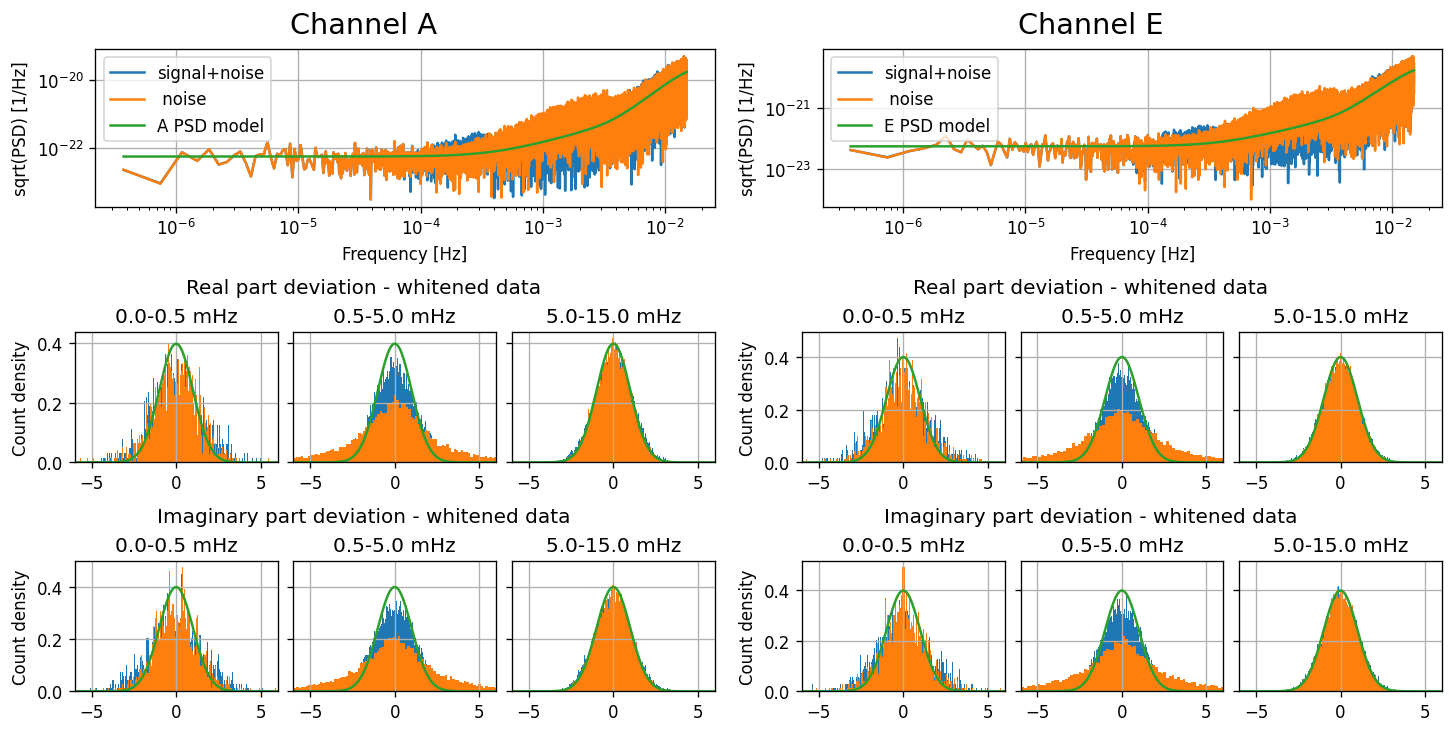

In [17]:
# plot comparison
plot_compare_spectra_timeseries(data = [td_datans, td_datan] ,
                                freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['signal+noise', ' noise'], 
                                save = False)

## 6. Data imputation with Spritz data and masked glitches
Do this again with the Spritz noise data + masked glitches

In [18]:
from bayesdawn.connect.maskglitches import BH_lowpass,detect_glitch_outliers, mask_glitches

(numpy.record, [('t', '<f8'), ('A', '<f8'), ('E', '<f8'), ('T', '<f8')])
A
E
T


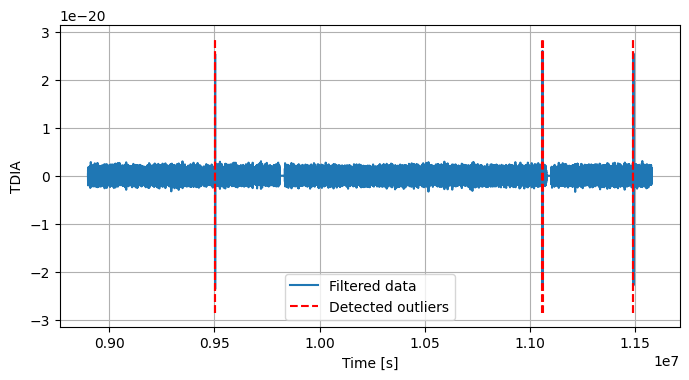

In [19]:
# specify number of gaps and number of glitches
GAPNUM = 2
GLITCHNUM = 3
# lowpass filter the data to detect outliers
lp_data = BH_lowpass(td_datangg, 
                     t_win = 100, # lowpass window length
                     t_sam = 5, # sampling time of output data
                     fs=0.2) # input data sampling frequency

# detect outliers
peaks = detect_glitch_outliers(lp_data, plot = True, threshold = 10)

# create glitch masked data
td_glitchmask = mask_glitches(td_datangg, peaks, glitchnum=GLITCHNUM, n = 5)

In [20]:
# import lisabeta_fill_gaps as fill_gaps
from bayesdawn.connect.fillgaps import get_ldc_gap_mask

In [21]:
# set number of glitches and gaps
gg = GAPNUM + GLITCHNUM
# create empty mask
mask = np.ones(td_glitchmask.shape[0])
ndata = td_glitchmask.shape[0]
# generate ldc data gap mask on the glitch-masked data
spritzglitchgaps = get_ldc_gap_mask(td_glitchmask, mode='index')
gapstarts,gapends= np.vsplit(spritzglitchgaps, 2)

for k in range(gapstarts.shape[1]):
    mask[gapstarts.reshape((gg))[k]:gapends.reshape((gg))[k]]=0

spritzglitchmask = {'mask': mask,
              'starts': gapstarts.reshape((gg)),
              'ends': gapends.reshape((gg))}

Text(0, 0.5, 'Spritz gap mask')

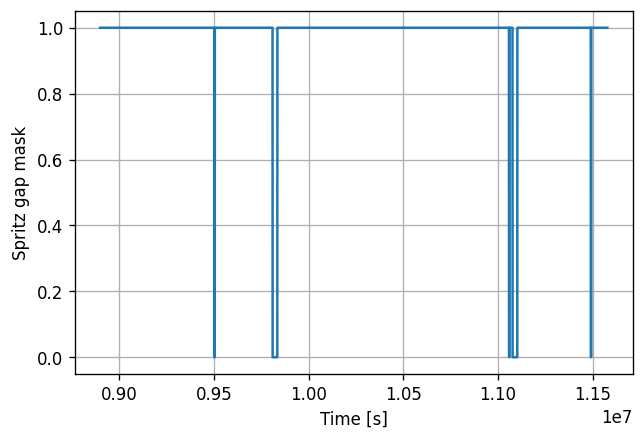

In [22]:
fig,ax = plt.subplots(1,1,dpi=120)
# ax.plot(maskinfo['mask'])
ax.plot(td_datag['t'],spritzglitchmask['mask'])
ax.grid()
ax.set_xlabel('Time [s]')
ax.set_ylabel('Spritz gap mask')

In [23]:
# from lisabeta_fill_gaps import view_gaps
from bayesdawn.connect.fillgaps import view_gaps

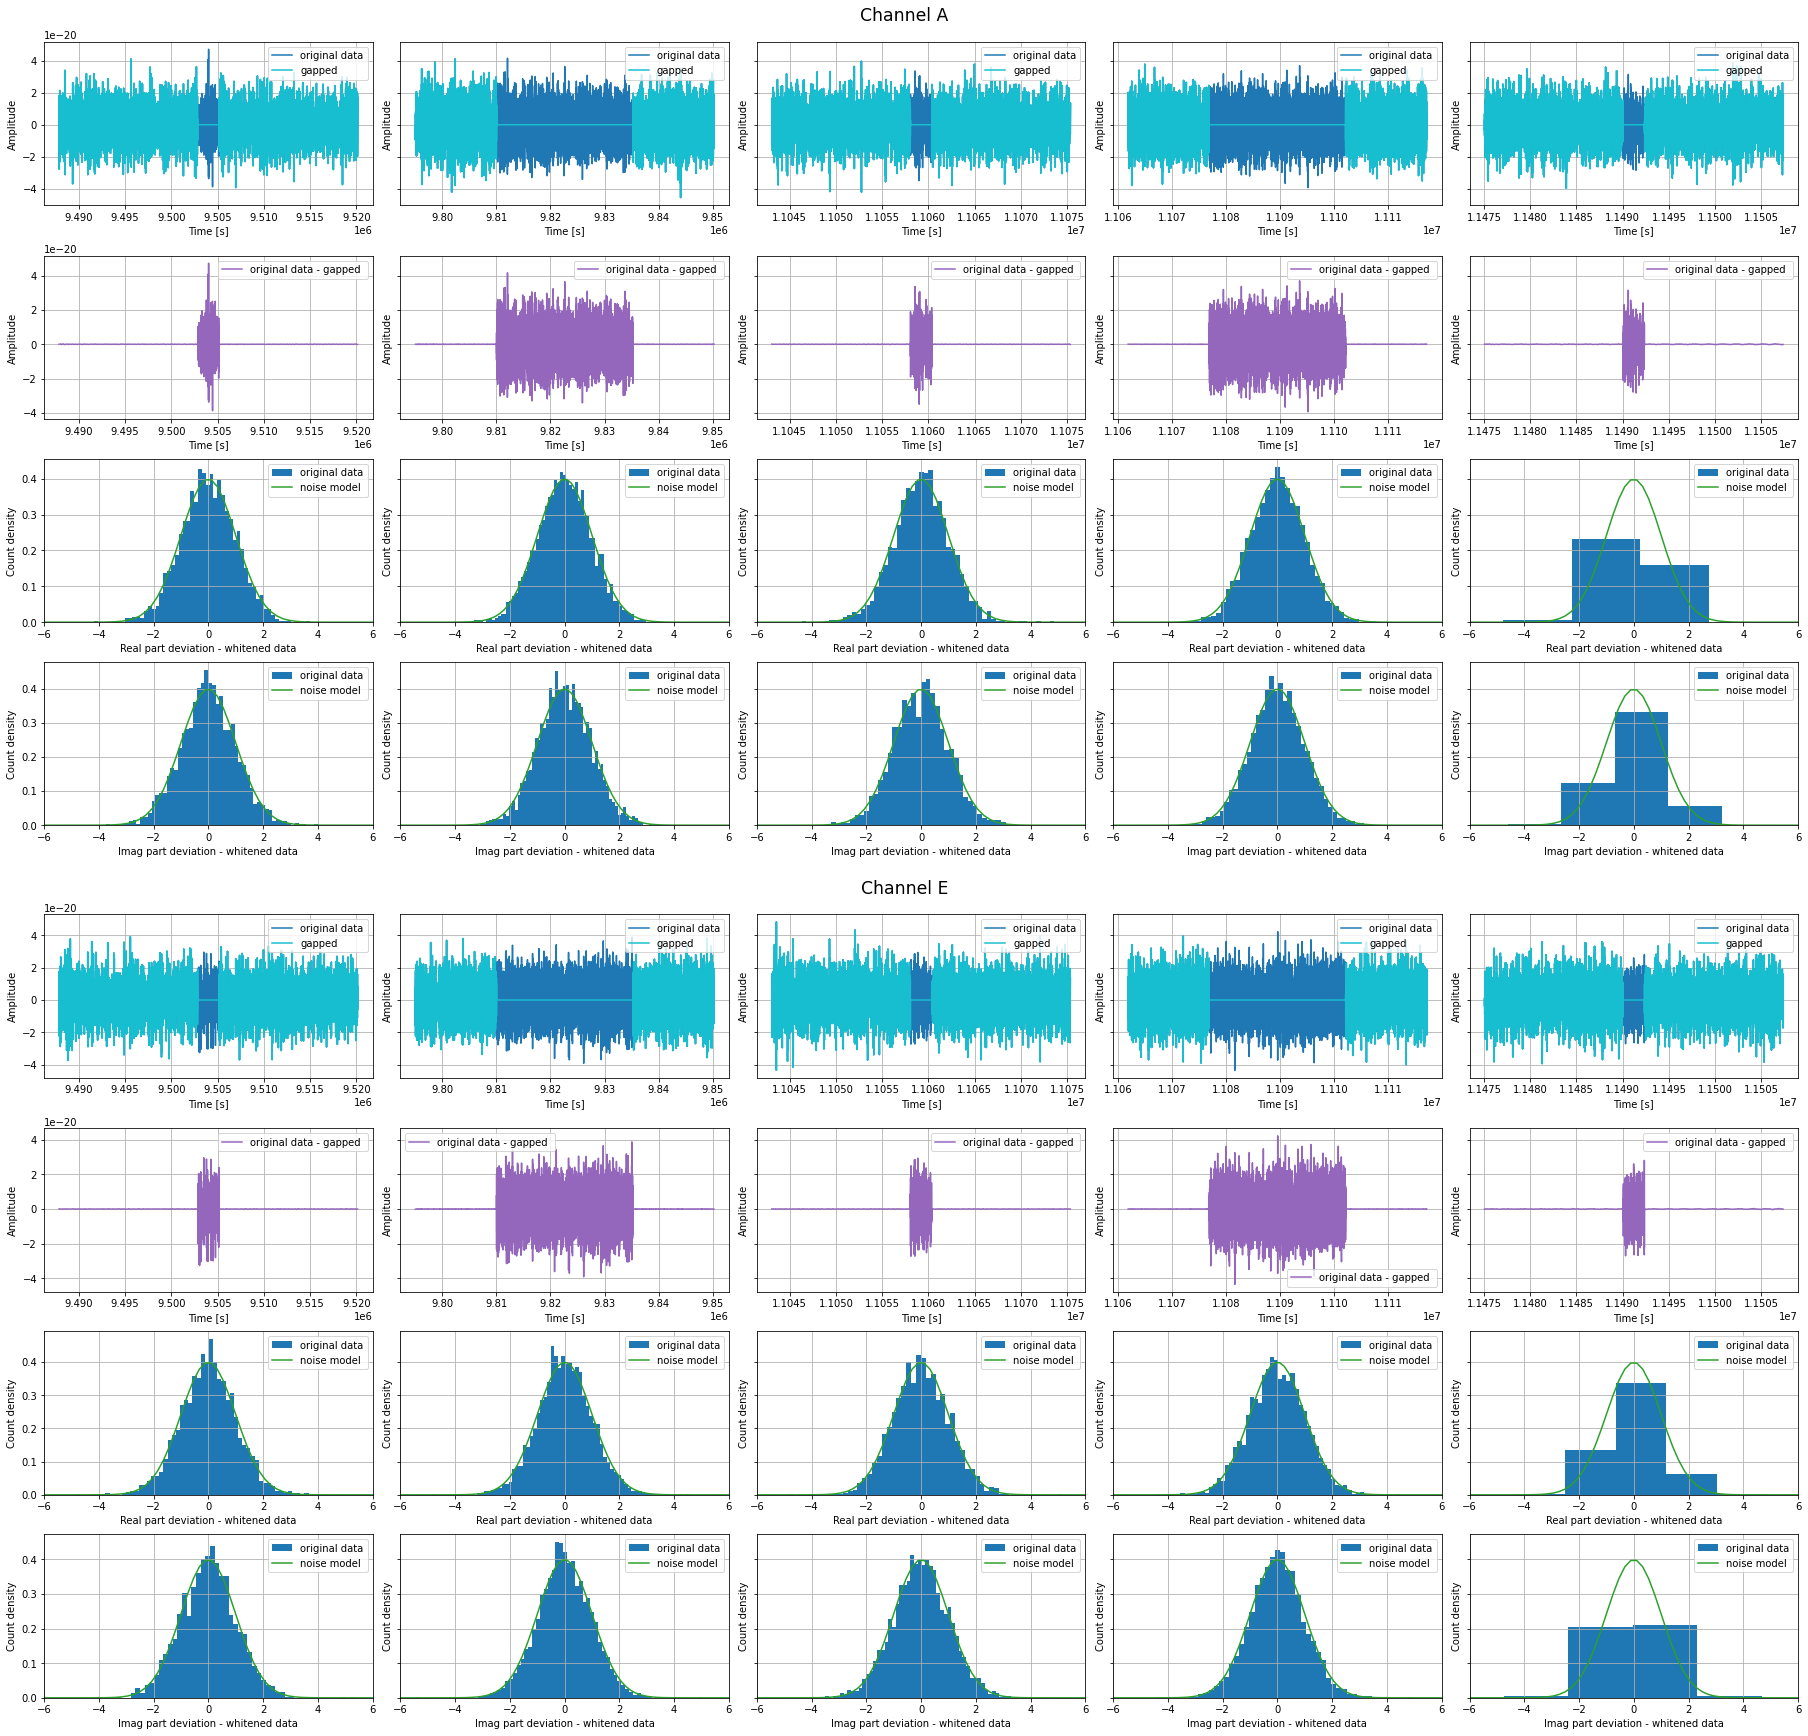

In [24]:
view_gaps(ts = td_datan['t'],
          ys = [[td_datans[names] for names in td_datans.dtype.names[1:]]],
          yg = [td_glitchmask[names] for names in td_glitchmask.dtype.names[1:]],
          maskinfo = spritzglitchmask, channels = ['A', 'E'],
          labels=['original data'], nwing = 3000, histogram=True)

### 5.3 Apply imputation to noise data and compare spectra

In [25]:
from bayesdawn.connect.fillgaps import create_imputation, update_imputation

In [26]:
# data imputation with iteration loop
# create empty arrays for the imputation
imp_cls = []
psd_cls = []
y_res = []
# create reconstructed data array with empty A, E, T fields
td_data_rec = np.rec.fromarrays([td_glitchmask['t']]+3*[np.zeros(len(td_glitchmask['t']))], 
                               names = td_glitchmask.dtype.names)
# set up flags and variables
names=['A', 'E']
mask = spritzglitchmask['mask']
n_iter = 10
fit_type = 'log_spline'
fit_dof = 15
k = 20

fmin = 1 / t_obs * k

print(' `fmin` value is {:.2e}'.format(fmin))

# perform data imputation

## initialize imputation

for tdi in names:
    t1 = time.time()
    psd_cls, imp_cls, y_res = create_imputation(td_glitchmask, tdi, mask, noise_model = 'spritz')
    td_data_rec[tdi] = y_res
    
    for i in range(n_iter):
        psdmod, imp_cls, y_res = update_imputation(data_rec = td_data_rec, imp_cls = imp_cls, channel = tdi,
                                                  fit_type = fit_type, fit_dof=fit_dof, fmin=fmin)
        td_data_rec[tdi] = y_res
    t2 = time.time()
    print("Imputation for combination " + tdi + " took " + str(t2-t1))
    ax.legend(loc='best')
    ax.grid()

 `fmin` value is 7.47e-06


/Users/ecastel2/Documents/LISA/research/GSFC/gap-filling/code/gap-venv/lib/python3.10/site-packages/bayesdawn-0.1.0-py3.10.egg/bayesdawn/datamodel.py:340: UserWarning: The maximum size of gap + conditional is high.


Computation of autocovariance + PSD took 7.62679123878479


TypeError: 'NoneType' object is not subscriptable

In [ ]:
view_gaps(ts = td_datag['t'],
          ys = [[td_datans[names] for names in td_datans.dtype.names[1:]], 
                [td_data_rec[names] for names in td_data_rec.dtype.names[1:]]],
          yg = [td_glitchmask[names] for names in td_glitchmask.dtype.names[1:]],
          maskinfo = spritzmask, channels = ['A', 'E'], nwing = 5000,
          labels=['original', 'reconstructed', 'gapped data'],
          save = SAVE)

In [ ]:
# generate fft and psd from reconstructed data
fdatan_rec, psddata_rec, _ = generate_freq_data(td_data_rec, split = True, fmin = fmin, win='boxcar') 

In [ ]:
# plot comparison
plot_compare_spectra_timeseries(data = [td_datans, td_data_rec],#,data_masked], 
                                  freq_bands=[5e-4, 5e-3],
                                fmin = fmin, fmax = 1.5e-2,
                               labels = ['Downavg original signal+noise', 'Reconstructed signal+noise'],#, 'gapped data'], 
                                save = SAVE)